In [1]:
import pandas as pd
import os
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
import itertools as it
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis,
                                           QuadraticDiscriminantAnalysis)
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import shuffle
from scipy import stats
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)
from statsmodels.sandbox.stats.multicomp import TukeyHSDResults
from sklearn.metrics import roc_curve
from sklearn import preprocessing

## Cargamos dataset

In [2]:
# Cargamos dataset Breast Cancer Wisconsin (Original)
ds = pd.read_csv('./breast-cancer-wisconsin.data', usecols=[1,2,3,4,5,6,7,8,9,10], 
                 names=[0,1,2,3,4,5,6,7,8,9], header=None)

In [3]:
output = 9
# Transformamos la columna de clases a 0-1 (actualmente son 2,4)
ds[output] = np.uint8(ds[output]/2-1)
# y = ds[output].values
# X = ds.drop(output,axis=1).values

## Preprocesado de datos

**Hacemos undersampling para intentar mejorar los resultados**  
Ya que después de unas pruebas preliminares con el dataset desbalanceado obteníamos mucha diferencia entre Sensibilidad y Especificidad.

In [4]:
ds_u = ds.copy()
# Número de casos positivos
nposit = len(ds_u[ds_u[output] == 1])
# Índices de casos negativos
inegat = ds_u[ds_u[output] == 0].index
# Cogemos aleatoriamente un número de índices negativos
# igual al número de casos positivos
random_indices = np.random.choice(inegat, nposit, replace=False)
# Obtenemos todos los índices positivos
iposit = ds_u[ds_u[output] == 1].index
# Unimos las dos listas de índices
new_indices = np.concatenate([iposit, random_indices])
ds_u = ds_u.loc[new_indices]
# y las desordenamos
ds_u = shuffle(ds_u).reset_index(drop=True)

X_u = ds_u.drop(output, axis=1)
y_u = ds_u[output]

X = X_u.values
y = y_u.values

**Comprobamos que no haya "missing values"**  
Según https://archive.ics.uci.edu/ml/datasets, los Missing Values están etiquetados como '?'.  
Eliminamos las filas con dicho valor.

In [5]:
rows = np.argwhere(X == '?')[:,0]
X = np.delete(X,rows,0)
y = np.delete(y,rows)
X = X.astype(np.uint8)

In [6]:
attr = []
# Iteramos los atributos del dataset
for i in ds.columns:
    # Comprobamos los valores de cada atributo
    attr.append(np.all(ds[i].notna()))
# Ningún atributo tiene missing values:
np.all(np.array(attr))

True

**Comprobamos que no haya variables con "near-zero variance"**  
Vemos que no hay ninguna.

In [7]:
ds.columns.drop(output)[ds.std() < 0.001]

Int64Index([], dtype='int64')

**Comprobamos que no haya variables iguales**  
Vemos que no hay ninguna.

In [8]:
resultados = np.zeros((len(ds.columns), len(ds.columns)))
for i in range(len(ds.columns)):
    for j in range(len(ds.columns)):
        resultados[i, j] = np.mean(ds.iloc[:, i] == ds.iloc[:, j])

In [9]:
iguales = []
for i, j in it.combinations(range(len(ds.columns)), 2):
    if round(resultados[i, j], 4) == 1:
        iguales.append(ds.columns[i])
        print(ds.columns[i], ds.columns[j])

**Comprobamos que las clases no estén desbalanceadas**  
Ya no están desbalanceadas ya que hemos hecho undersampling.

In [10]:
y = np.array([i for i,j in enumerate(set(y)) for k in y if j == k])

In [11]:
print('Proporción clase 0: ',np.mean(y==0))
print('Proporción clase 1: ',np.mean(y==1))

Proporción clase 0:  0.49789915966386555
Proporción clase 1:  0.5021008403361344


**Desordenamos los datos**

In [12]:
X,y = shuffle(X,y)

## Detección de Outliers

In [13]:
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)

In [14]:
y_pred = clf.fit_predict(X)

In [15]:
X_scores = clf.negative_outlier_factor_

**Este procedimiento no tiene mucho sentido con valores discretos**

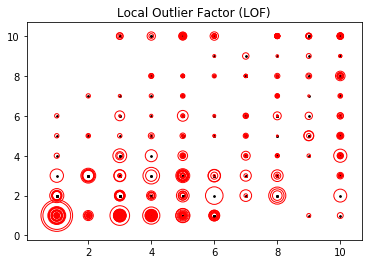

In [16]:
plt.title("Local Outlier Factor (LOF)")
plt.scatter(X[:, 0], X[:, 1], color='k', s=3., label='Data points')
# plot circles with radius proportional to the outlier scores
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
plt.scatter(X[:, 0], X[:, 1], s=1000 * radius, edgecolors='r',
            facecolors='none', label='Outlier scores')
plt.show()

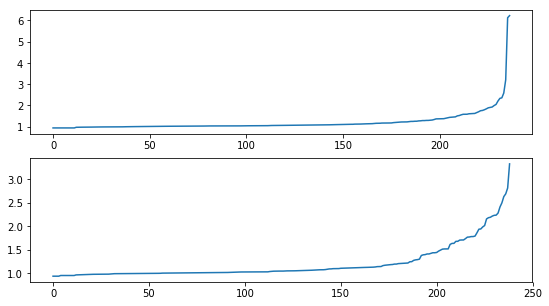

In [17]:
f, ax = plt.subplots(2,1,figsize=(9,5))
for i in set(y):
    temp = X[y == i]
    y_pred = clf.fit_predict(temp)
    temp_scores = clf.negative_outlier_factor_
    ax[i].plot(range(len(temp_scores)),sorted(-temp_scores))

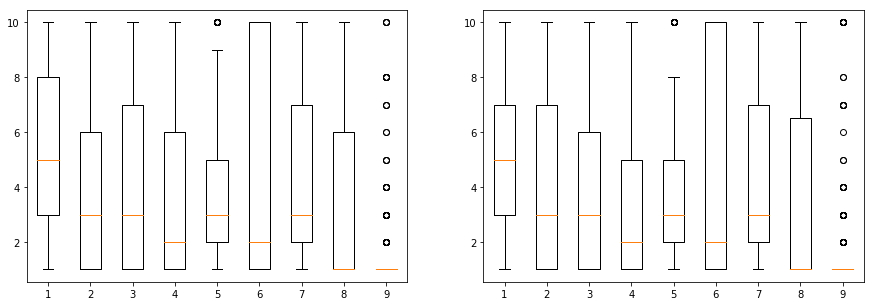

In [18]:
f, ax = plt.subplots(1,2,figsize=(15,5))
for i in set(y):
    temp = X[y == i]
    data = []
    for j in range(X.shape[1]):
        data.append(temp[:,j])
    bp = ax[i].boxplot(data)
plt.show()

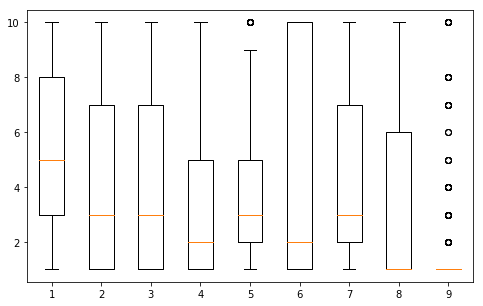

In [19]:
# Create a figure instance
fig = plt.figure(figsize=(8, 5))
# Create an axes instance
ax = fig.add_subplot(111)
data = []
for j in range(X.shape[1]):
    data.append(X[:,j])
bp = ax.boxplot(data)
plt.show()

## Entrenamiento de Modelos

**kFold - Linear Discriminant Analysis**

In [20]:
kf = KFold(n_splits=10)
resultados_train = []
resultados_test = []
for tipo in ('lsqr', 'eigen', 'svd'):
    for _ in range(3):
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            alg = LinearDiscriminantAnalysis(solver=tipo, shrinkage=None)
            alg.fit(X_train, y_train)
            resultados_train.append(alg.score(X_train, y_train))
            resultados_test.append(alg.score(X_test, y_test))
resultados_train = np.reshape(resultados_train,(30,3),order='F')
resultados_test = np.reshape(resultados_test,(30,3),order='F')

**Test de normalidad**  
Rechazamos normalidad

In [21]:
print(stats.shapiro(resultados_test[:,0])[1])
print(stats.shapiro(resultados_test[:,1])[1])
print(stats.shapiro(resultados_test[:,2])[1])

0.001978374784812331
0.008589164353907108
0.001978374784812331


**Test de Kruskal-Wallis**  
No se puede rechazar que las precisiones sean similares

In [22]:
print(stats.kruskal(resultados_test[:,0],
                    resultados_test[:,1],
                    resultados_test[:,2]))

KruskalResult(statistic=0.8826446280992115, pvalue=0.6431853654804824)


**kFold - Quadratic Discriminant Analysis**

In [23]:
# kf = KFold(n_splits=10)
kf = KFold(n_splits=5)
resultados_trainq = []
resultados_testq = []
# for _ in range(3):
for _ in range(6):
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        alg = QuadraticDiscriminantAnalysis(priors=np.array([1/3, 1/3]))
        alg.fit(X_train, y_train)
        resultados_trainq.append(alg.score(X_train, y_train))
        resultados_testq.append(alg.score(X_test, y_test))

**Test de normalidad**  
Rechazamos normalidad

In [24]:
print(stats.shapiro(resultados_testq)[1])

3.106720032519661e-05


**Test de Kruskal-Wallis**  
No se puede rechazar que las precisiones sean similares

In [25]:
print(stats.kruskal(resultados_test[:,0],
                    resultados_test[:,1],
                    resultados_test[:,2],
                    resultados_testq))

KruskalResult(statistic=10.881551920882458, pvalue=0.012383918425381363)


**Tukey**  
Ya que no podemos rechazar que las precisiones sean similares,  
este test no es necesario (sin embargo, sin hacer el undersampling sí haría falta).

In [26]:
resultados_test = resultados_test.flatten("F")
resultados_testq = np.array(resultados_testq)
resultados_test = np.concatenate((resultados_test,resultados_testq))
labels = [i for i in "0123" for _ in range(int(resultados_test.shape[0]/4))]

In [33]:
resultados = pairwise_tukeyhsd(resultados_test,labels)
resultados.summary()

group1,group2,meandiff,lower,upper,reject
0,1,-0.0063,-0.0329,0.0203,False
0,2,0.0,-0.0266,0.0266,False
0,3,0.0272,0.0006,0.0538,True
1,2,0.0063,-0.0203,0.0329,False
1,3,0.0335,0.0069,0.0601,True
2,3,0.0272,0.0006,0.0538,True


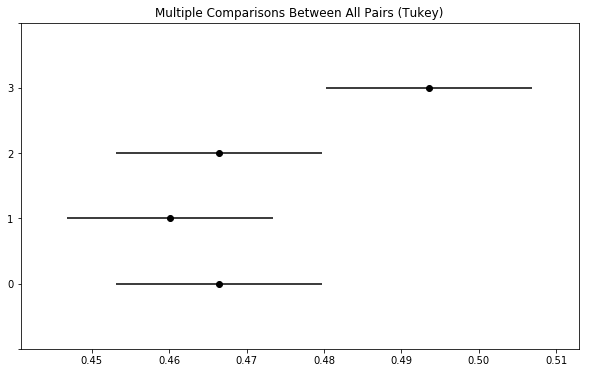

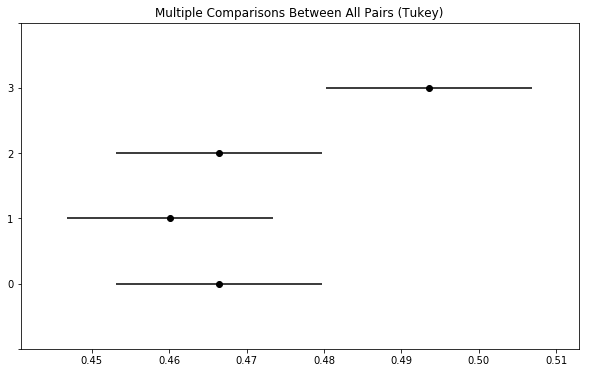

In [28]:
resultados.plot_simultaneous()

**Hold Out**  
//TODO: mover este cálculo a cada iteración del k-fold.  
No obtenemos buenos resultados, nos queda pendiente descubrir el por qué.

In [29]:
def performance_indexes(CM, PositiveClass):
    classNum = len(CM)
    TP = CM[PositiveClass, PositiveClass]
    TN = 0
    FP = 0
    FN = 0
    for real in range(classNum):
        for predicted in range(classNum):
            if (real != PositiveClass and predicted != PositiveClass):
                TN += CM[real, predicted]
            if (real != PositiveClass and predicted == PositiveClass):
                FP += CM[real, predicted]
            if (real == PositiveClass and predicted != PositiveClass):
                FN += CM[real, predicted]
    Sens = TP/(TP+FN)
    Spec = TN/(TN+FP)
    PPV = TP/(TP+FP)
    NPV = TN/(TN+FN)
    ACC = (TP+TN)/(TP+TN+FP+FN)
    return Sens,Spec,PPV,NPV,ACC

In [30]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25)
alg = LinearDiscriminantAnalysis(solver='lsqr', shrinkage=None)
alg.fit(X_train, y_train)
y_pred = alg.predict(X_test)
CM = confusion_matrix(y_test, y_pred)
Sens,Spec,PPV,NPV,ACC = performance_indexes(CM,0)
print(('Sens: {:.2f}, Spec: {:.2f}, PPV: {:.2f}, ' +
      'NPV: {:.2f}, ACC: {:.2f}').format(Sens,Spec,PPV,NPV,ACC))
alg.score(X_test, y_test)

Sens: 0.46, Spec: 0.57, PPV: 0.51, NPV: 0.52, ACC: 0.51


0.5126050420168067

In [31]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25)
alg = QuadraticDiscriminantAnalysis(priors=np.array([1/3, 1/3]))
alg.fit(X_train, y_train)
y_pred = alg.predict(X_test)
CM = confusion_matrix(y_test, y_pred)
Sens,Spec,PPV,NPV,ACC = performance_indexes(CM,0)
print(('Sens: {:.2f}, Spec: {:.2f}, PPV: {:.2f}, ' +
      'NPV: {:.2f}, ACC: {:.2f}').format(Sens,Spec,PPV,NPV,ACC))
alg.score(X_test, y_test)

Sens: 0.28, Spec: 0.69, PPV: 0.46, NPV: 0.50, ACC: 0.49


0.48739495798319327

**----------------------------------------------------------------------------------------------------------------------------**

## Persistencia

In [32]:
# with open('RForest_Zika_oversampled.bin','wb') as file:
#     pickle.dump(alg_o, file)
# with open('RForest_Zika_undersampled.bin','wb') as file:
#     pickle.dump(alg_u, file)

## FIN